# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [38]:
import logging
import warnings

# Suppress warnings from Gradio / Vertex AI
logging.getLogger("google").setLevel(logging.ERROR)
logging.getLogger("vertexai").setLevel(logging.ERROR)
logging.getLogger("gradio").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [1]:
# imports
import sys
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool

import base64
from IPython.display import Image, display

In [4]:
sys.path.append('/run/media/sijanpaudel/New Volume1/New folder/llm_engineering')

In [5]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
api_key = os.getenv("GOOGLE_API_KEY_1")

if api_key:
    print(f"Google API Key exists and begins {api_key[:8]}")
else:
    print("Google API Key not set")

Google API Key exists and begins AIzaSyB8


In [ ]:
MODEL = "gemini-2.0-flash"
model = ChatGoogleGenerativeAI(model=MODEL, api_key=api_key)

In [141]:
system_message = (
    "You are a helpful assistant for an airline called FlightAI. "
"Whenever the user asks for a ticket price, you **must call the 'get_ticket_price' function** to get the correct price. "
"Do not guess or make up prices. Give short, courteous answers in a natural way."
)

In [142]:
from google.ai.generativelanguage_v1beta.types import Tool as GenAITool

resp = model.invoke(
    "What is today's Date?",
    tools=[GenAITool(google_search={})],
)

print(resp.content)
print("\nUsage Metadata:")
print(resp.usage_metadata)

Today is Saturday, September 20, 2025.

Usage Metadata:
{'input_tokens': 7, 'output_tokens': 16, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}}


In [ ]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    print(f"{messages}\n\n\n")
    response = model.invoke(messages)
    return response.content

gr.ChatInterface(fn=chat, type="messages").launch()

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [ ]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [ ]:
get_ticket_price("London")

In [25]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    """
    Python function that returns the price of a ticket to a given city.
    Get the price of a return ticket to the destination city.Call this whenever you need to know the ticket price, for example " "when a customer asks 'How much is a ticket to this city'
    Args:
        destination_city (str): Name of the city
    Returns:
        str: Ticket price or 'Unknown' if the city is not listed
    """
    print(f"[TOOL] get_ticket_price called with destination_city='{destination_city}'")
    city = destination_city.lower()  # Normalize input for dictionary lookup
    price = ticket_prices.get(city, "Unknown")
    print(f"[TOOL] Returning price: {price}")
    return price

tools = [get_ticket_price]

In [ ]:
get_ticket_price("Berlin")

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

def chat(user_input, history):
    print(f"\n[CHAT] User input: {user_input}")

    # Build conversation messages
    messages = [SystemMessage(content="You are a helpful assistant.")] # Assuming a system message
    for h in history:
        role = HumanMessage if h["role"] == "user" else AIMessage
        messages.append(role(content=h["content"]))
    messages.append(HumanMessage(content=user_input))

    # Bind tools and force usage
    model_with_tools = model.bind_tools(tools, tool_choice="any")
    response = model_with_tools.invoke(messages)

    # Check if the model made a tool call
    if tool_calls := getattr(response, "tool_calls", None):
        # --- Start of Changes ---

        # 1. Append the model's response (which contains the tool call) to the history
        messages.append(response)

        # 2. Execute each tool call and create a ToolMessage for each
        for tool_call in tool_calls:
            city = tool_call["args"]["destination_city"]
            price = get_ticket_price(city)
            print(f"[TOOL] Called get_ticket_price for '{city}', returned: {price}")
            
            # 3. Append the ToolMessage with the result and the original tool_call_id
            messages.append(ToolMessage(
                content=str(price), # The content should be the raw output of the tool
                tool_call_id=tool_call['id']
            ))

        # --- End of Changes ---

        # Call model again so it can respond naturally
        response = model.invoke(messages)
        print(f"[CHAT] Response is: {response.content}")

    return response.content

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [6]:
TEXT_MODEL = "gemini-2.0-flash"
IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"

In [7]:
# --- Function Definition ---

def _get_image_base64(response_message: AIMessage) -> str | None:
    """
    Extracts the base64-encoded image string from an AIMessage response.

    Args:
        response_message (AIMessage): The response object returned by the LLM, 
                                      which may contain text and/or image data.

    Returns:
        str | None: The base64 string of the image if found, 
                    otherwise None.
    """
    # Iterate through all content blocks in the AI response
    for block in response_message.content:
        # Check if the block is a dictionary and contains an "image_url" key
        if isinstance(block, dict) and "image_url" in block:
            # The "url" value is in the format: "data:image/png;base64,<base64string>"
            # Split by ',' and return only the base64 part
            return block["image_url"]["url"].split(",")[-1]
    
    # Return None if no image block is found
    return None


In [10]:

print(f"➡️ Trying API key: {api_key[:6]} (Gmail: )")

➡️ Trying API key: AIzaSy (Gmail: )


In [14]:
import base64
from IPython.display import Image, display
sys.path.append('/run/media/sijanpaudel/New Volume1/New folder/llm_engineering')



def generate(prompt: str, model, max_retries=5):
    """
    Generates and displays an image using a model instance with automatic API key rotation.

    Args:
        prompt: The text description of the image to generate.
        model_class: The model class to initialize (e.g., ChatGoogleGenerativeAI)
        model_name: The name of the model (e.g., "gemini-2.0-flash")
        max_retries: Maximum number of keys to try in case of quota errors
    """
    message = {"role": "user", "content": prompt}

    print(f"Generating image for: '{prompt}' \n")

    for _ in range(max_retries):
        # api_key, gmail_name = get_next_key()
        # print(f"➡️ Trying API key: {api_key[:6]} (Gmail: {gmail_name})")
        try:
            # --- TASK SECTION (CUSTOMIZE THIS) ---

            
            # Example for image generation:
            #
            model = ChatGoogleGenerativeAI(model=model, google_api_key=api_key)
            response = model.invoke(
                [message],
                generation_config={"response_modalities": ["TEXT", "IMAGE"]},
            )
            print(response.content[0])
            image_base64 = _get_image_base64(response)
            print(image_base64)
            if image_base64:
                display(Image(data=base64.b64decode(image_base64),width=400))
            else:
                print("Could not extract image from the response.")
            # RETURN the result if needed
            return 

            
            # -------------------------------------

        except Exception as e:
            if "quota" in str(e).lower() or "exceeded" in str(e).lower():
                print(f"⚠️ Quota exceeded for key {api_key[:6]}... trying next key.")
                continue
            else:
                raise  # For other errors, raise immediately

    raise RuntimeError("❌ All API keys failed or quota exceeded.")


In [ ]:
generate("Generate a photorealistic image of a cuddly cat wearing a hat.", model=IMAGE_MODEL)

Generating image for: 'An image representing a vacation in Pokhara, showing tourist spots and everything unique about Pokhara, in a vibrant pop-art style' 

➡️ Trying API key: AIzaSy (Gmail: paudelsijan15)
I will generate a vibrant pop-art style image showcasing a Pokhara vacation. The scene will include iconic tourist spots like Phewa Lake with colorful boats, the Annapurna mountain range in a stylized manner in the background, and perhaps a glimpse of the World Peace Pagoda. Elements unique to Pokhara, such as paragliders in bold colors and traditional Nepali architecture with exaggerated features, will be incorporated. The overall style will feature bright, contrasting colors, thick outlines, and a playful, graphic feel characteristic of pop art.


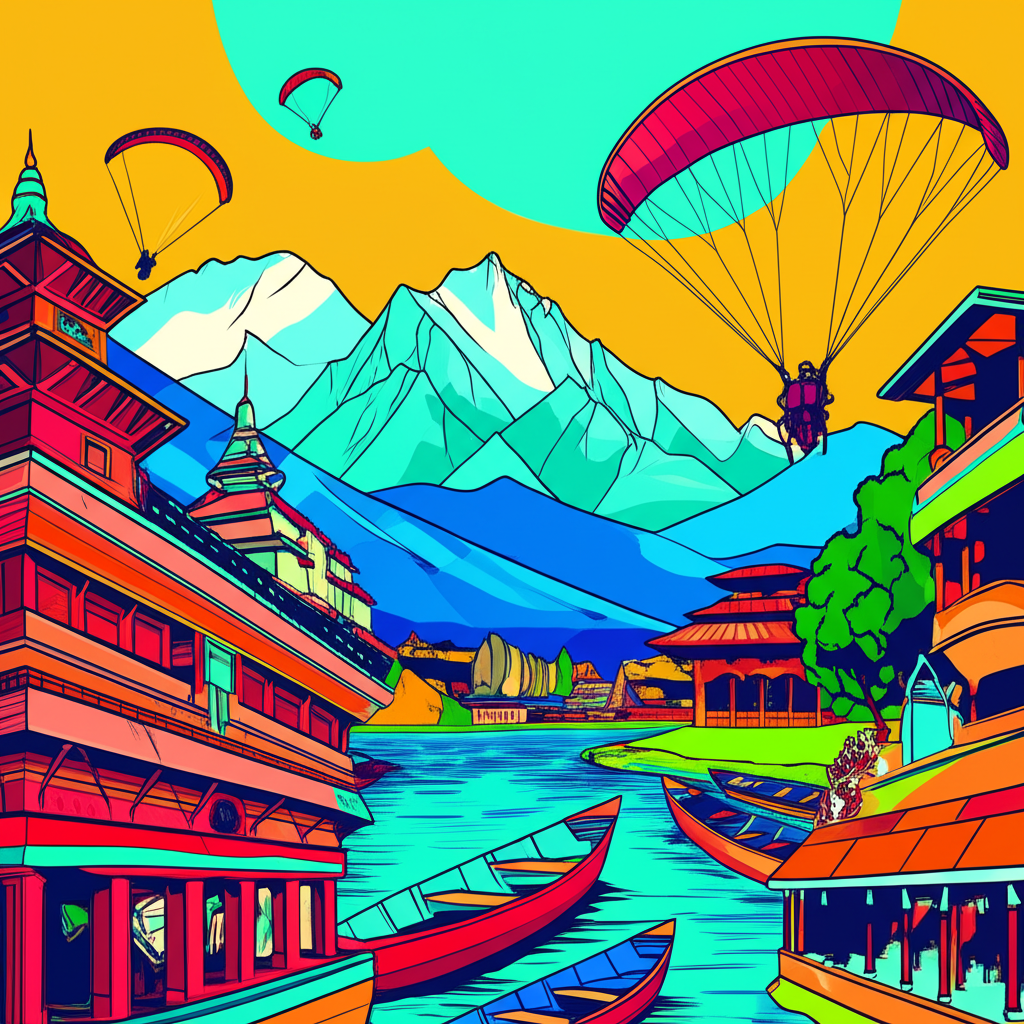

In [18]:
city = "Pokhara"
prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style"
generate(prompt,IMAGE_MODEL)

In [136]:
import sys
sys.path.append(r'/run/media/sijanpaudel/New Volume1/New folder')  # parent folder

from llm_engineering.key_utils import get_next_key

<function llm_engineering.key_utils.get_next_key()>

In [19]:
## import base64
from IPython.display import Image, display
from llm_engineering.key_utils import get_next_key


def generate_with_history(prompt: str,history: list, model, max_retries=5):
    """
    Generates and displays an image using a model instance with automatic API key rotation.

    Args:
        prompt: The text description of the image to generate.
        model_class: The model class to initialize (e.g., ChatGoogleGenerativeAI)
        model_name: The name of the model (e.g., "gemini-2.0-flash")
        max_retries: Maximum number of keys to try in case of quota errors
    """
    message = {"role": "user", "content": prompt}
    history.append(message)


    print(f"Generating image for: '{prompt}' \n")

    for _ in range(max_retries):
        api_key, gmail_name = get_next_key()
        print(f"➡️ Trying API key: {api_key[:10]} (Gmail: {gmail_name})")
        try:
            # --- TASK SECTION (CUSTOMIZE THIS) ---

            
            # Example for image generation:
            #
           
            model = ChatGoogleGenerativeAI(model=model, google_api_key=api_key,max_retries=1)
            response = model.invoke(
                history,
                generation_config={"response_modalities": ["TEXT", "IMAGE"]},
                retry=False
            )
            print(response.content[0])
            image_base64 = _get_image_base64(response)
            if image_base64:
                display(Image(data=base64.b64decode(image_base64),width=400))
            else:
                print("Could not extract image from the response.")
                
            # RETURN the result if needed
            history.append(response)
            return response

            
            # -------------------------------------

        except PermissionDenied as e:
            print(f"⚠️ Key {api_key[:6]} failed (PermissionDenied). Skipping to next key...")
            continue

        except Exception as e:
            msg = str(e).lower()
            if "quota" in msg or "exceeded" in msg or "service_disabled" in msg:
                print(f"⚠️ Key {api_key[:6]} failed ({e.__class__.__name__}). Trying next key...")
                continue
            else:
                raise

    raise RuntimeError("❌ All API keys failed or quota exceeded.")


Generating image for: 'Generate a photorealistic image of a cuddly cat wearing a hat.' 

➡️ Trying API key: AIzaSyBCM8 (Gmail: aayushkafle)
I will generate a photorealistic image of an adorable, fluffy tabby cat with bright green eyes, comfortably nestled on a soft, cream-colored blanket. The cat will be wearing a small, knitted blue beanie hat slightly tilted on its head. The lighting will be soft and warm, highlighting the texture of the cat's fur and the knit of the hat.


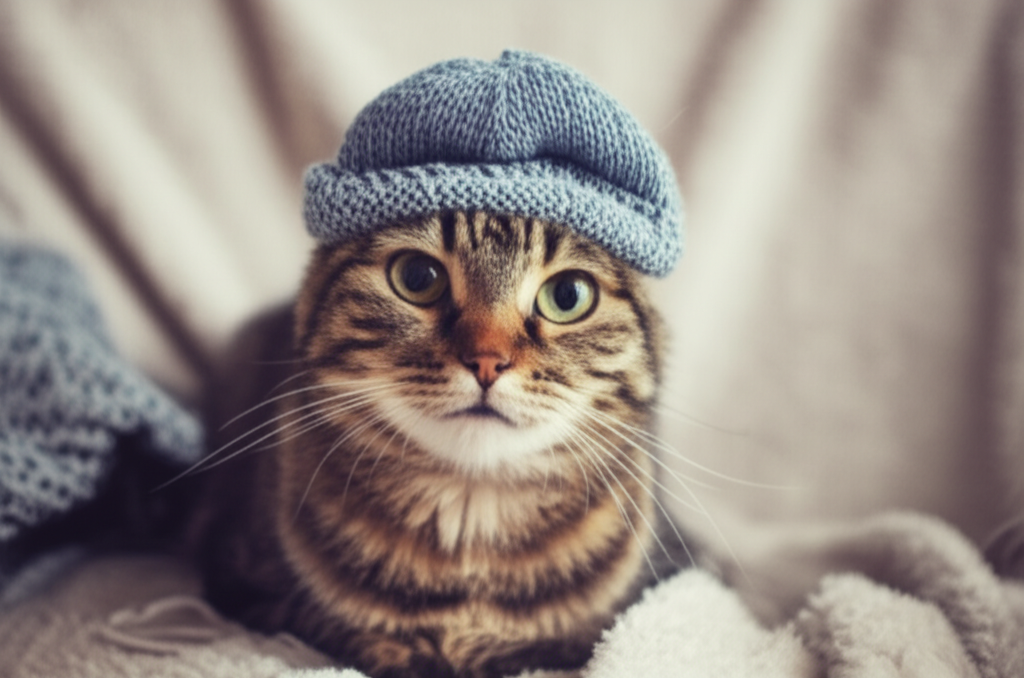

Generating image for: 'Can you take the same image and make the cat black?' 

➡️ Trying API key: AIzaSyBARg (Gmail: aasutoshregmi)
I will edit the previous image to change the tabby cat to a sleek, black cat while maintaining the same pose, green eyes, blue beanie hat, and cream-colored blanket under soft, warm lighting.


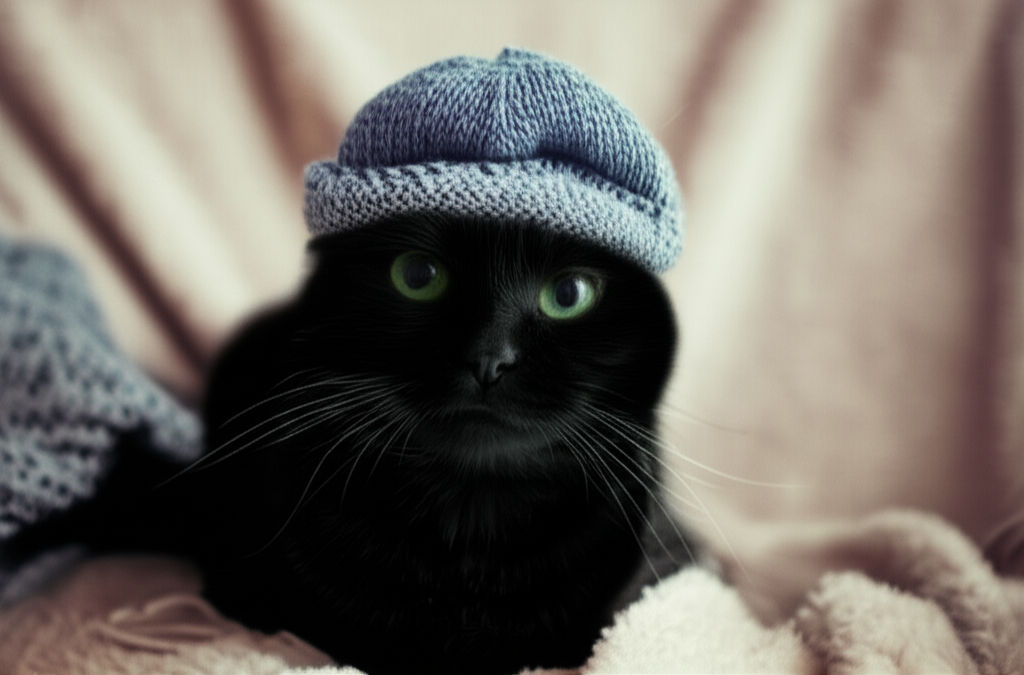

In [20]:
conversation_history = []

resp1 = generate_with_history("Generate a photorealistic image of a cuddly cat wearing a hat.", conversation_history, IMAGE_MODEL)
resp2 = generate_with_history("Can you take the same image and make the cat black?", conversation_history, IMAGE_MODEL)


In [21]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [ ]:
image = artist("New York City")
display(image)

In [6]:
!pwd

/run/media/sijanpaudel/New Volume1/New folder/llm_engineering/week2


In [8]:
from LLMHandler import LLMHandler
handler = LLMHandler()

In [9]:
def prompt(city):
    return (
        f"An image representing a vacation in {city}, showing tourist spots "
        f"and everything unique about {city}, in a vibrant pop-art style"
    )


In [10]:
# Example usage
city = "Paris"
generated_prompt = prompt(city)

Generating image for: An image representing a vacation in New York City, showing tourist spots and everything unique about New York City, in a vibrant pop-art style
➡️ Using API key: AIzaSyA6Jo of sijan.paudel10 (Attempt 1)


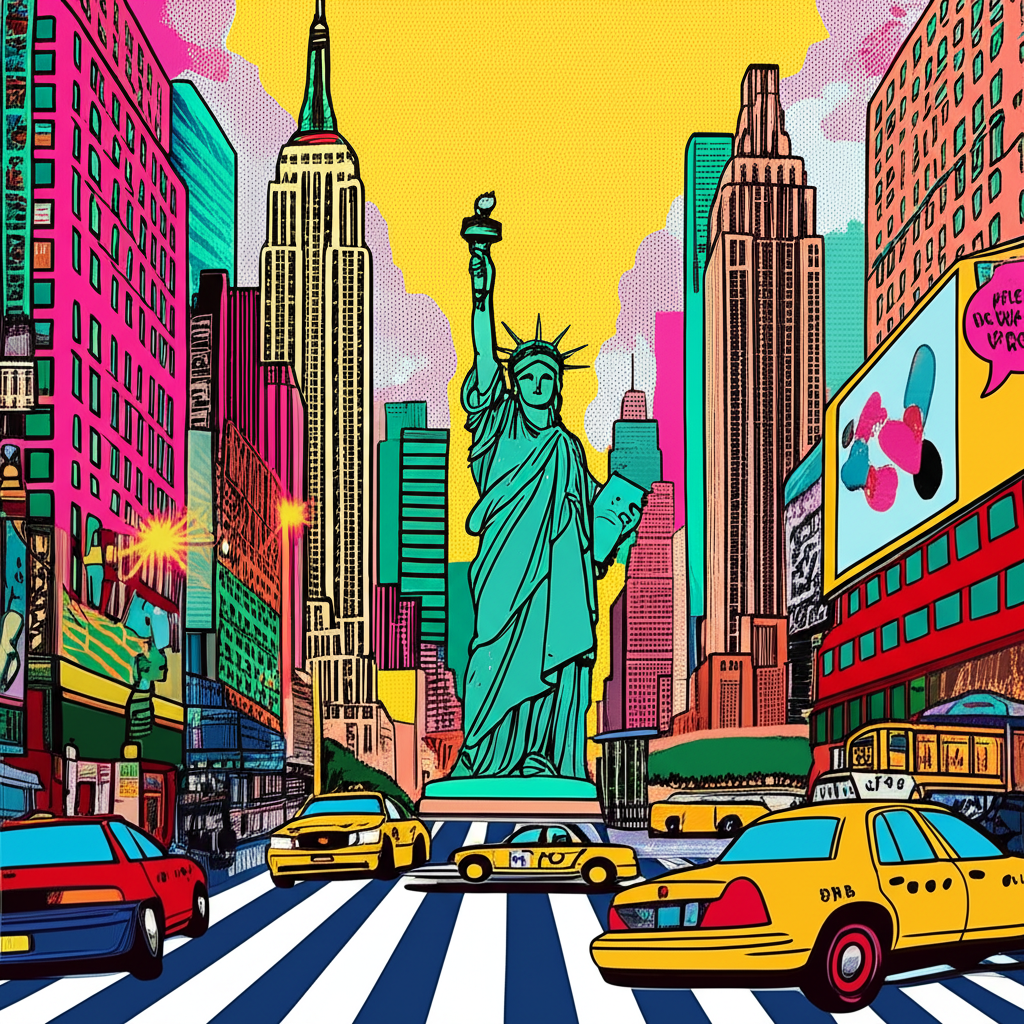

image_generated


In [12]:
response = handler.generate_image(
    user_input=prompt("New York City"),height=1024,width=1024
)
print(response)


## Audio (NOTE - Audio is optional for this course - feel free to skip Audio if it causes trouble!)

And let's make a function talker that uses OpenAI's speech model to generate Audio

### Troubleshooting Audio issues

If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

**For PC Users**

Detailed instructions are [here](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905) and summary instructions:

1. Download FFmpeg from the official website: https://ffmpeg.org/download.html

2. Extract the downloaded files to a location on your computer (e.g., `C:\ffmpeg`)

3. Add the FFmpeg bin folder to your system PATH:
- Right-click on 'This PC' or 'My Computer' and select 'Properties'
- Click on 'Advanced system settings'
- Click on 'Environment Variables'
- Under 'System variables', find and edit 'Path'
- Add a new entry with the path to your FFmpeg bin folder (e.g., `C:\ffmpeg\bin`)
- Restart your command prompt, and within Jupyter Lab do Kernel -> Restart kernel, to pick up the changes

4. Open a new command prompt and run this to make sure it's installed OK
`ffmpeg -version`

**For Mac Users**

1. Install homebrew if you don't have it already by running this in a Terminal window and following any instructions:  
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Then install FFmpeg with `brew install ffmpeg`

3. Verify your installation with `ffmpeg -version` and if everything is good, within Jupyter Lab do Kernel -> Restart kernel to pick up the changes

Message me or email me at ed@edwarddonner.com with any problems!

## To check you now have ffmpeg and can access it here

Excecute the next cell to see if you get a version number. (Putting an exclamation mark before something in Jupyter Lab tells it to run it as a terminal command rather than python code).

If this doesn't work, you may need to actually save and close down your Jupyter lab, and start it again from a new Terminal window (Mac) or Anaconda prompt (PC), remembering to activate the llms environment. This ensures you pick up ffmpeg.

And if that doesn't work, please contact me!

In [ ]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

# For Mac users - and possibly many PC users too

This version should work fine for you. It might work for Windows users too, but you might get a Permissions error writing to a temp file. If so, see the next section!

As always, if you have problems, please contact me! (You could also comment out the audio talker() in the later code if you're less interested in audio generation)

In [ ]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [ ]:
talker("Well, hi there")

In [90]:
import base64
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
# Native Gemini SDK
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted


In [134]:
import langchain_google_genai.chat_models as chat_mod

# --- Save original retry function ---
_original_chat_with_retry = chat_mod._chat_with_retry

# --- Function to enable or disable internal retry externally ---
def retry(enable: bool):
    if enable:
        chat_mod._chat_with_retry = _original_chat_with_retry
    else:
        def no_retry(**kwargs):
            generation_method = kwargs.pop("generation_method")
            metadata = kwargs.pop("metadata", None)
            return generation_method(
                request=kwargs.get("request"),
                retry=None,
                timeout=None,
                metadata=metadata
            )
        chat_mod._chat_with_retry = no_retry

In [148]:
def talker(message: str):
    """
    Generate speech from Gemini TTS and play it.
    """
    # 1. Initialize the TTS model
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-tts",api_key=api_key)

    # 2. Get audio bytes
    try:
        response = llm.invoke(
            [HumanMessage(content=message)],
            generation_config={
                "response_modalities": ["AUDIO"],
                "speech_config": {},  # No 'voice' field needed
            },
        )
        print(response)
    
        # ✅ Access the audio bytes from additional_kwargs
        audio_bytes = response.additional_kwargs.get('audio')
        if not audio_bytes:
            print("❌ No audio found in response.")
            return
    
        # Convert raw WAV bytes to AudioSegment
        audio_segment = AudioSegment.from_file(BytesIO(audio_bytes), format="wav")
    
        print(f"Playing audio for: '{message}'")
        play(audio_segment)

    except ResourceExhausted as e:
        print("Quota exceeded! Please try again later.")
        # You can also access e.retry_after or e.details if needed
        print(e)

    except GoogleAPICallError as e:
        print("API call failed:", e)
    
    except Exception as e:
        print("Some other error occurred:", e)



In [ ]:
import base64
from IPython.display import Image, display
sys.path.append('/run/media/sijanpaudel/New Volume1/New folder/llm_engineering')
from key_utils import get_next_key


def generate(prompt: str, model, max_retries=5):
    """
    Generates and displays an image using a model instance with automatic API key rotation.

    Args:
        prompt: The text description of the image to generate.
        model_class: The model class to initialize (e.g., ChatGoogleGenerativeAI)
        model_name: The name of the model (e.g., "gemini-2.0-flash")
        max_retries: Maximum number of keys to try in case of quota errors
    """
    message = {"role": "user", "content": prompt}

    print(f"Generating image for: '{prompt}' \n")

    for _ in range(max_retries):
        api_key, gmail_name = get_next_key()
        print(f"➡️ Trying API key: {api_key[:6]} (Gmail: {gmail_name})")
        try:
            # --- TASK SECTION (CUSTOMIZE THIS) ---
            # 1. Initialize the TTS model
            llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-tts",api_key=api_key)
        
            # 2. Get audio bytes
            try:
                response = llm.invoke(
                    [HumanMessage(content=message)],
                    generation_config={
                        "response_modalities": ["AUDIO"],
                        "speech_config": {},  # No 'voice' field needed
                    },
                )
                print(response)
            
                # ✅ Access the audio bytes from additional_kwargs
                audio_bytes = response.additional_kwargs.get('audio')
                if not audio_bytes:
                    print("❌ No audio found in response.")
                    return
            
                # Convert raw WAV bytes to AudioSegment
                audio_segment = AudioSegment.from_file(BytesIO(audio_bytes), format="wav")
            
                print(f"Playing audio for: '{message}'")
                play(audio_segment)
        
            except ResourceExhausted as e:
                print("Quota exceeded! Please try again later.")
                # You can also access e.retry_after or e.details if needed
                print(e)
        
            except GoogleAPICallError as e:
                print("API call failed:", e)
            
            except Exception as e:
                print("Some other error occurred:", e)
                    
            
            # -------------------------------------

        except Exception as e:
            if "quota" in str(e).lower() or "exceeded" in str(e).lower():
                print(f"⚠️ Quota exceeded for key {api_key[:6]}... trying next key.")
                continue
            else:
                raise  # For other errors, raise immediately

    raise RuntimeError("❌ All API keys failed or quota exceeded.")


In [15]:
import time

start_time = time.time() 
print("HI")
handler.generate_audio("This is a test of the text to speech system.")
end_time = time.time()

print(round(end_time - start_time,3))

HI
➡️ Using API key: AIzaSyBCM8 of aayushkafle (Attempt 1)


Input #0, wav, from '/tmp/tmp851b77zz.wav':   0KB sq=    0B 
  Duration: 00:00:03.77, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   3.52 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


9.523


   3.71 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

# For Windows users (or any Mac users with problems above)

## First try the Mac version above, but if you get a permissions error writing to a temp file, then this code should work instead.

A collaboration between students Mark M. and Patrick H. and Claude got this resolved!

Below are 4 variations - hopefully one of them will work on your PC. If not, message me please!

And for Mac people - all 3 of the below work on my Mac too - please try these if the Mac version gave you problems.

## PC Variation 1

In [ ]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

## PC Variation 2

In [ ]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # Student Dominic found that this was needed. You could also try commenting out to see if not needed on your PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

talker("Well hi there")

## PC Variation 3

In [ ]:
import os
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO

def talker(message):
    # Set a custom directory for temporary files on Windows
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.environ['TEMP'] = custom_temp_dir  # You can also use 'TMP' if necessary
    
    # Create the folder if it doesn't exist
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    play(audio)

talker("Well hi there")

## PC Variation 4

### Let's try a completely different sound library

First run the next cell to install a new library, then try the cell below it.

In [ ]:
!pip install simpleaudio

In [ ]:
from pydub import AudioSegment
from io import BytesIO
import tempfile
import os
import simpleaudio as sa

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Create a temporary file in a folder where you have write permissions
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
        temp_file_name = temp_audio_file.name
        audio.export(temp_file_name, format="wav")
    
    # Load and play audio using simpleaudio
    wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
    play_obj = wave_obj.play()
    play_obj.wait_done()  # Wait for playback to finish

    # Clean up the temporary file afterward
    os.remove(temp_file_name)
    
talker("Well hi there")

## PC Users - if none of those 4 variations worked!

Please get in touch with me. I'm sorry this is causing problems! We'll figure it out.

Alternatively: playing audio from your PC isn't super-critical for this course, and you can feel free to focus on image generation and skip audio for now, or come back to it later.

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [5]:
from LLMHandler import LLMHandler
handler = LLMHandler()

In [34]:
# Let's start by making a useful function
from langchain_core.tools import tool
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    """
    Python function that returns the price of a ticket to a given city.
    Get the price of a return ticket to the destination city.Call this whenever you need to know the ticket price, for example " "when a customer asks 'How much is a ticket to this city'
    Args:
        destination_city (str): Name of the city
    Returns:
        str: Ticket price or 'Unknown' if the city is not listed
    """
    print(f"[TOOL] get_ticket_price called with destination_city='{destination_city}'")
    city = destination_city.lower()  # Normalize input for dictionary lookup
    price = ticket_prices.get(city, "Unknown")
    print(f"[TOOL] Returning price: {price}")
    return price

tools = [get_ticket_price]

In [6]:
import threading

In [46]:
# # ----------------------------
# # 6️⃣ TEXT WITH TOOLS
# # ----------------------------
# print("=== TEXT WITH TOOLS ===")
# # Define tools as list
# def get_ticket_price(destination_city):
#     prices = {"paris": "$120", "berlin": "$150"}
#     return prices.get(destination_city.lower(), "Price unknown")

# tools = [get_ticket_price]

# response = handler.run("What is the price to Paris",tools=tools,task_type="text")
# print(response["data"])
# response = handler.run("and to berlin?", tools=tools,task_type="text")
# print(response["data"])


In [35]:
response = handler.run("What is the price to Paris",tools=tools,task_type="text")
print(response["data"])
response = handler.run("and to berlin?", tools=tools,task_type="text")
print(response["data"])


➡️ Attempt 1/11 using key from 'saharamanandhar'...
[TOOL] get_ticket_price called with destination_city='Paris'
[TOOL] Returning price: $899
✅ [TOOL] Called 'get_ticket_price' with {'destination_city': 'Paris'}. Result: $899
The price to Paris is $899.
➡️ Attempt 1/11 using key from 'sijanpaudel'...
[TOOL] get_ticket_price called with destination_city='Berlin'
[TOOL] Returning price: $499
✅ [TOOL] Called 'get_ticket_price' with {'destination_city': 'Berlin'}. Result: $499
The price to Berlin is $499.


In [31]:
# --- THIS IS THE FIX ---
# We are giving the AI a very specific, forceful instruction.
system_instruction = """
You are a specialized flight price assistant. 
Your primary and most important task is to use the `get_flight_price` tool.
If a user mentions a city or expresses a desire to travel, you MUST use the `get_flight_price` tool to give them the price immediately. 
Do not ask for clarifying details like dates or budget before providing the price. 
If the user does not specify a departure city, assume it is 'New York'.
"""
handler = LLMHandler(system_message=system_instruction)
print("✅ LLMHandler initialized for Gradio with a specific tool-forcing prompt.")

✅ LLMHandler initialized for Gradio with a specific tool-forcing prompt.


In [50]:
# Let's start by making a useful function
from langchain_core.tools import tool
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}
@tool
def get_ticket_price(destination_city):
    """
    Python function that returns the price of a ticket to a given city.
    Get the price of a return ticket to the destination city.Call this whenever you need to know the ticket price, for example " "when a customer asks 'How much is a ticket to this city'
    Args:
        destination_city (str): Name of the city
    Returns:
        str: Ticket price or 'Unknown' if the city is not listed
    """
    print(f"[TOOL] get_ticket_price called with destination_city='{destination_city}'")
    city = destination_city.lower()  # Normalize input for dictionary lookup
    price = ticket_prices.get(city, "Unknown")
    print(f"[TOOL] Returning price: {price}")
    return price

tools = [get_ticket_price]

In [51]:
response = handler.run("What is the price to Paris",tools=tools,task_type="text")
print(response["data"])
response = handler.run("and to berlin?", tools=tools,task_type="text")
print(response["data"])


➡️ Attempt 1/11 using key from 'sijanpaudel'...
❌ [TOOL] Error: Tool 'get_ticket_price' not found.
I am programmed to use a tool to search for flight prices, but it seems I am having trouble accessing it right now. Please try again in a few minutes.
➡️ Attempt 1/11 using key from 'sijan.paudel10'...
❌ [TOOL] Error: Tool 'get_ticket_price' not found.
I am programmed to use a tool to search for flight prices, but it seems I am having trouble accessing it right now. Please try again in a few minutes.


In [48]:
import gradio as gr
import base64
import tempfile # Needed to save audio files temporarily
from datetime import datetime
import os
from PIL import Image
import io

# --------------------------------------------------------------------------
# Step 1: Create a single, persistent instance of your handler
# --------------------------------------------------------------------------
print("✅ LLMHandler initialized for Gradio.")

# --------------------------------------------------------------------------
# Step 2: Create a single, persistent instance of your handler WITH A DIRECTIVE
# --------------------------------------------------------------------------
# --- THIS IS A CRITICAL FIX ---
# Give the AI a specific, forceful instruction about its job.
system_instruction = """
You are a specialized flight price assistant. 
Your primary and most important task is to use the `get_flight_price` tool whenever a user mentions a city or a desire to travel.
Do not ask for clarifying details. Use the tool immediately. 
If the user does not specify a departure city, assume it is 'New York'.
"""
handler = LLMHandler(system_message=system_instruction)
print("✅ LLMHandler initialized for Gradio with a specific tool-forcing prompt.")

# --------------------------------------------------------------------------
# Step 3: Put your tools in a list (The "Toolbox")
# --------------------------------------------------------------------------
# --- THIS IS A CRITICAL FIX ---
# The toolbox is no longer empty.

print(f"✅ Tools loaded: {[t.__name__ for t in tools]}")
def handle_text_and_image(message, chat_history):
    """
    This is the FIRST function in the chain. It handles the user's input,
    generates the text or image, and immediately updates the chat UI.
    It returns the assistant's text reply to be passed to the next function.
    """
    image_output_data = None
    assistant_reply_text = "" # Initialize empty reply for the audio function

    # Append user message to the chat display
    chat_history.append({"role": "user", "content": message})

    if message.lower().strip().startswith("/image"):
        prompt = message[7:].strip()
        if not prompt:
            assistant_reply_text = "Please provide a prompt after the /image command."
        else:
            print(f"🖼️  Image generation requested for: '{prompt}'")
            # --- Call the unified run method for an image ---
            response_dict = handler.run(prompt, task_type="image")
            
            # --- FIX: Directly and safely handle the dictionary response ---
            if response_dict and response_dict.get('type') == 'image':
                assistant_reply = "Here is the image you requested:"
                image_base64 = response_dict.get('data')
                if image_base64:
                # Convert base64 to PIL Image
                    image_bytes = base64.b64decode(image_base64)
                    image_output_data = Image.open(io.BytesIO(image_bytes))
            else:
                assistant_reply = "Sorry, I couldn't generate the image."
    
        # Append the assistant's confirmation/error message to the chat display
        chat_history.append({"role": "assistant", "content": assistant_reply_text})

    else:
        print(f"💬 Text/Tool generation requested for: '{message}'")
        # FIX: We now pass the populated 'tools' list to the handler
        response_dict = handler.run(message, tools=tools, task_type="text")
        if response_dict and response_dict.get('type') == 'text':
            assistant_reply = response_dict['data']
        else:
            assistant_reply = "Sorry, an error occurred."
        
        chat_history.append({"role": "assistant", "content": assistant_reply})

    return "", chat_history, image_output_data, assistant_reply



def generate_audio_in_background(assistant_reply_text):
    """
    This is the SECOND function in the chain. It runs after the text is displayed.
    It takes the assistant's text, generates audio, and updates the audio player.
    """
    if not assistant_reply_text:
        return None # Do nothing if there's no text

    print(f"🎤 Audio generation requested for: '{assistant_reply_text[:50]}...'")
    audio_response_dict = handler.run(assistant_reply_text, task_type="audio")
    
    if audio_response_dict and audio_response_dict.get('type') == 'audio' and audio_response_dict.get('data'):
        audio_bytes = audio_response_dict['data']
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_audio_file:
            temp_audio_file.write(audio_bytes)
            print(f"✅ Audio saved to temporary file: {temp_audio_file.name}")
            return temp_audio_file.name
    else:
        print("❌ Failed to generate audio.")
        return None

def clear_chat():
    """ Resets the handler's memory and all UI components. """
    print("--- Clearing Chat History ---")
    handler.clear_history()
    # The return signature must match the number of outputs for all components
    return [], None, None, None



✅ LLMHandler initialized for Gradio.
✅ LLMHandler initialized for Gradio with a specific tool-forcing prompt.
✅ Tools loaded: ['get_ticket_price']


In [49]:
# --------------------------------------------------------------------------
# Step 5: Build the Gradio UI (unchanged from before)
# --------------------------------------------------------------------------
with gr.Blocks(theme=gr.themes.Soft(), title="Multimodal AI Assistant") as ui:
    # ... (the UI layout is identical to the previous version) ...
    gr.Markdown("# 🤖 Multimodal AI Assistant")
    with gr.Row():
        chatbot = gr.Chatbot(label="Conversation", height=500, type="messages")
        image_output = gr.Image(label="Generated Image", height=500, interactive=True)
    entry = gr.Textbox(label="Your Message", placeholder="Type your message or use /image <prompt>...")
    audio_player = gr.Audio(label="Assistant's Voice", autoplay=True, interactive=True)
    assistant_reply_for_audio = gr.Textbox(visible=False)
    clear_btn = gr.Button("Clear Chat", variant="stop")

    text_event = entry.submit(fn=handle_text_and_image, inputs=[entry, chatbot], outputs=[entry, chatbot, image_output, assistant_reply_for_audio])
    text_event.then(fn=generate_audio_in_background, inputs=[assistant_reply_for_audio], outputs=[audio_player])
    clear_btn.click(fn=clear_chat, inputs=None, outputs=[chatbot, image_output, audio_player, assistant_reply_for_audio])

# Launch the Gradio app
ui.launch(inbrowser=True, debug=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Opening in existing browser session.
💬 Text/Tool generation requested for: 'price london'
➡️ Attempt 1/11 using key from 'birajmohanta'...
[TOOL] get_ticket_price called with destination_city='london'
[TOOL] Returning price: $799
✅ [TOOL] Called 'get_ticket_price' with {'destination_city': 'london'}. Result: $799
🎤 Audio generation requested for: 'The price to London is $799....'
➡️ Attempt 1/11 using key from 'saharamanandhar'...
✅ Audio saved to temporary file: /tmp/tmpx3yx34_9.wav
Keyboard interruption in main thread... closing server.


In [ ]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [ ]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>

In [ ]:
    # --- THE UNIFIED RUN METHOD ---
    def run(self, user_input, task_type="text", tools=None, max_retries=11, enable_retry=False,width=400,height=None, stream=False):
        """
        A single, unified method to handle text, audio, image, and tool generation.
        This method RETURNS data instead of displaying it.
        
        Args:
            user_input (str or list): The user's prompt or message.
            task_type (str): The type of task ("text", "audio", "image", etc.).
            tools (list, optional): A list of tools for the model to use. Defaults to None.
            max_retries (int): The maximum number of times to retry with a new API key.
            enable_retry (bool): Whether to enable the internal LangChain retry mechanism.
            width (int): The display width for generated images.
            height (int): The display height for generated images.
            stream (bool): If True for text generation, yields the response in chunks.
            
        Returns:
            dict: A dictionary containing the result for non-streaming tasks.
            Generator[str]: If stream=True for a text task, yields response content in chunks.
        """
        self._patch_retry(enable_retry)
        
                # 1. Select model
        model_name = {
            "text": self.TEXT_MODEL,
            "tool": self.TEXT_MODEL,
            "audio": self.AUDIO_MODEL,
            "image": self.IMAGE_MODEL,
            "audio_transcription": self.TEXT_MODEL,
            "video_transcription": self.TEXT_MODEL,
            "image_analysis": self.TEXT_MODEL, #Use the multimodal model for transcription
        }.get(task_type, self.TEXT_MODEL)

        # 2. Build messages (with a special case for transcription)
        if task_type in ["audio_transcription", "video_transcription",  "image_analysis"]:
            # For transcription, the user_input is already a fully formed HumanMessage
            messages = [user_input]
        else:
            messages = self._build_messages(user_input, task_type=task_type)
        
        # 3. Centralized Retry Loop
        for attempt in range(max_retries):
            api_key, user_name = get_next_key()
            print(f"➡️ Attempt {attempt + 1}/{max_retries} using key from '{user_name}'...")
            
            try:
                llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=api_key)
                
                # 4. Handle different task types
                if task_type == "audio":
                    tts_message = [HumanMessage(content=user_input)] # Use only the direct input for TTS
                    response = llm.invoke(tts_message, generation_config={"response_modalities": ["AUDIO"]})
                    audio_bytes = response.additional_kwargs.get("audio")
                    self._update_history(user_input, "[Generated audio in response to prompt]")
                    return {"type": "audio", "data": audio_bytes, "text": response.content}

                elif task_type == "image":
                    # For images, we just need the user prompt
                    response = llm.invoke(messages, generation_config={"response_modalities": ["TEXT","IMAGE"]})
                    image_base64 = self._get_image_base64(response)
                    if image_base64:
                        display(Image(data=base64.b64decode(image_base64), width=width, height=height))
                        # Save only prompt for reference
                        self._update_history(user_input, "[Generated image in response to prompt]")
                        print( "image_generated")
                        return {"type": "image", "data": image_base64, "text": "Image generated successfully."}
                    else:
                        print("No image returned")

                else: # Handles "text", "tool", and transcriptions
                    model_to_invoke = llm
                    if tools:
                        model_to_invoke = llm.bind_tools(tools, tool_choice="any")
                    
                    # --- MODIFIED: Streaming and Non-Streaming Logic ---
                    # Handle streaming as a special case that returns a generator
                    if stream and task_type == 'text' and not tools:
                        def stream_and_update_history():
                            full_response_content = ""
                            try:
                                for chunk in model_to_invoke.stream(messages):
                                    chunk_content = chunk.content
                                    full_response_content += chunk_content
                                    yield chunk_content
                            finally:
                                # This ensures history is updated even if the consumer stops iterating early
                                self._update_history(user_input, full_response_content)
                        
                        return stream_and_update_history() # Return the generator object

                    # --- Default Non-Streaming / Tool-Using Logic ---
                    response = model_to_invoke.invoke(messages)

                    # Tool Execution Logic
                    if response.tool_calls:
                        messages.append(response)
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            # Find the callable tool function
                            matched_tool_func = next((t for t in tools if getattr(t, '__name__', None) == tool_name), None)
                            if matched_tool_func:
                                result = matched_tool_func(**tool_args)
                                print(f"✅ [TOOL] Called '{tool_name}' with {tool_args}. Result: {result}")
                            else:
                                result = f"Error: Tool '{tool_name}' not found."
                                print(f"❌ [TOOL] {result}")
                            messages.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
                        
                        # Call the model again with the tool results
                        response = llm.invoke(messages)
                        
                    # UPDATED: Differentiated history logging
                    if task_type in ["audio_transcription", "video_transcription"]:
                        prompt_summary = f"[Transcription requested for a media file]"
                        self._update_history(prompt_summary, response.content)
                    elif task_type == "image_analysis":
                         # Extract the text part of the prompt for a better history log
                        prompt_text = next((part['text'] for part in user_input.content if isinstance(part, dict) and part['type'] == 'text'), 'Analyze image')
                        prompt_summary = f"[{prompt_text}]"
                        self._update_history(prompt_summary, response.content)
                    else:
                        self._update_history(user_input, response.content)
                        

                    return {"type": "text", "data": response.content, "text": response.content}

            except (ResourceExhausted, GoogleAPICallError, ValueError) as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e.__class__.__name__} - {e}")
                if attempt + 1 >= max_retries:
                    raise RuntimeError("All API keys failed or quota exceeded.") from e
                continue # Try the next key

        raise RuntimeError("All API keys failed or quota exceeded after all attempts.")

In [3]:
import sys
sys.path.append('/run/media/sijanpaudel/New Volume/New folder/llm_engineering')

In [53]:
import base64
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from google.api_core.exceptions import ResourceExhausted, GoogleAPICallError
from IPython.display import Image, display, Audio, Markdown
import mimetypes
import os

# Assuming key_utils.py exists and works
from key_utils import get_next_key

import langchain_google_genai.chat_models as chat_mod

class LLMHandler:
    # --- Model Constants ---
    # Using modern, flexible models that support conversation history is recommended
    TEXT_MODEL = "gemini-2.0-flash"
    AUDIO_MODEL = "gemini-2.5-flash-preview-tts"
    IMAGE_MODEL = "gemini-2.0-flash-preview-image-generation"
    def __init__(self, system_message="You are a helpful assistant."):
        self.conversation_history = []
        self.system_message = system_message
        self._original_chat_with_retry = chat_mod._chat_with_retry

 # --- Patch retry ---
    def _patch_retry(self, enable_retry: False):
        """Enable or disable internal retry inside LangChain/Google API"""
        if not enable_retry:
            def no_retry_chat_with_retry(**kwargs):
                generation_method = kwargs.pop("generation_method")
                metadata = kwargs.pop("metadata", None)
                return generation_method(
                    request=kwargs.get("request"),
                    retry=None,
                    timeout=None,
                    metadata=metadata
                )
            chat_mod._chat_with_retry = no_retry_chat_with_retry
        else:
            chat_mod._chat_with_retry = self._original_chat_with_retry
        
        # --- Helper: extract base64 image ---
    def _get_image_base64(self, response):
        for block in response.content:
            if isinstance(block, dict) and "image_url" in block:
                return block["image_url"]["url"].split(",")[-1]
        return None

    

    # --- REFACTORED AND FIXED: Message Building ---
    def _build_messages(self, user_input, task_type="text"):
        """
        Correctly builds the message list for the API, preserving history for all task types.
        """
        messages = []

        # FIX: Only add system message for conversational tasks that support it.
        if task_type in ["text", "tool"]:
            messages.append(SystemMessage(content=self.system_message))

        # FIX: Convert the entire history correctly for the model.
        for h in self.conversation_history:
            role = h.get("role")
            content = h.get("content")
            if role == "user":
                messages.append(HumanMessage(content=content))
            elif role == "assistant":
                messages.append(AIMessage(content=content))
        
        # Always add the latest user input.
        messages.append(HumanMessage(content=user_input))
        return messages

    # --- REFACTORED AND FIXED: History Updating ---
    def _update_history(self, user_input, assistant_response_content):
        """
        Correctly updates the internal history with the latest turn.
        """
        self.conversation_history.append({"role": "user", "content": user_input})
        # FIX: Always store the actual content from the assistant.
        self.conversation_history.append({"role": "assistant", "content": assistant_response_content})
    
    def clear_history(self):
        """Helper to reset the conversation."""
        self.conversation_history = []
        print("Conversation history cleared.")

    def _get_raw_stream_generator(self, user_input, llm, messages):
        """A private helper to create the base generator that includes history updates."""
        full_response_content = ""
        try:
            for chunk in llm.stream(messages):
                full_response_content += chunk.content
                yield chunk  # Yield the original LangChain message chunk
        finally:
            # This block executes when the generator is exhausted or closed.
            self._update_history(user_input, full_response_content)

        
            
    def stream_and_process(self, user_input, on_chunk_callback=None, **kwargs):
        """
        Streams a response, displays it in real-time as Markdown, and
        optionally processes each chunk with a user-provided callback function.

        This method handles the entire streaming lifecycle in one call.

        Args:
            user_input (str): The user's prompt.
            on_chunk_callback (callable, optional): A function to call on each
                response chunk. The function should accept one argument: the chunk.
            **kwargs: Additional arguments for the run() method.

        Returns:
            str: The final, complete response text.
        """
        # 1. Get the raw generator from the run method.
        kwargs['stream'] = True
        raw_generator = self.run(user_input, **kwargs)

        if not hasattr(raw_generator, '__iter__'):
             print("❌ Streaming failed. Could not get a generator.")
             return ""

        # 2. Set up the display and start the process. This all happens immediately.
        print("Assistant is responding...")
        display_handle = display(Markdown(""), display_id=True)
        full_response_content = ""

        # 3. Consume the generator internally, driving the entire process.
        try:
            for chunk in raw_generator:
                full_response_content += chunk.content
                
                # Action 1: Update the live Markdown display.
                display_handle.update(Markdown(f"""{full_response_content}"""))
                
                # Action 2: Execute the user's callback function if provided.
                if on_chunk_callback:
                    try:
                        on_chunk_callback(chunk)
                    except Exception as e:
                        print(f"🚨 Error in your callback function: {e}")
        finally:
            print("\n--- Stream finished ---")

        # 4. Return the final, assembled text.
        return full_response_content

    # --- THE UNIFIED RUN METHOD ---
    def run(self, user_input, task_type="text", tools=None, max_retries=11, enable_retry=False,width=400,height=None, stream=False, display_text=True):
        """
        A single, unified method to handle text, audio, image, and tool generation.
        This method RETURNS data instead of displaying it.
        
        Args:
            user_input (str or list): The user's prompt or message.
            task_type (str): The type of task ("text", "audio", "image", etc.).
            tools (list, optional): A list of tools for the model to use. Defaults to None.
            max_retries (int): The maximum number of times to retry with a new API key.
            enable_retry (bool): Whether to enable the internal LangChain retry mechanism.
            width (int): The display width for generated images.
            height (int): The display height for generated images.
            stream (bool): If True for text generation, yields the response in chunks.
            
        Returns:
            dict: A dictionary containing the result for non-streaming tasks.
            Generator[str]: If stream=True for a text task, yields response content in chunks.
        """
        self._patch_retry(enable_retry)
        
                # 1. Select model
        model_name = {
            "text": self.TEXT_MODEL,
            "tool": self.TEXT_MODEL,
            "audio": self.AUDIO_MODEL,
            "image": self.IMAGE_MODEL,
            "audio_transcription": self.TEXT_MODEL,
            "video_transcription": self.TEXT_MODEL,
            "image_analysis": self.TEXT_MODEL, #Use the multimodal model for transcription
        }.get(task_type, self.TEXT_MODEL)

        # 2. Build messages (with a special case for transcription)
        if task_type in ["audio_transcription", "video_transcription",  "image_analysis"]:
            # For transcription, the user_input is already a fully formed HumanMessage
            messages = [user_input]
        else:
            messages = self._build_messages(user_input, task_type=task_type)
        
        # 3. Centralized Retry Loop
        for attempt in range(max_retries):
            api_key, user_name = get_next_key()
            print(f"➡️ Attempt {attempt + 1}/{max_retries} using key from '{user_name}'...")
            
            try:
                llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=api_key)
                
                # 4. Handle different task types
                if task_type == "audio":
                    tts_message = [HumanMessage(content=user_input)] # Use only the direct input for TTS
                    response = llm.invoke(tts_message, generation_config={"response_modalities": ["AUDIO"]})
                    audio_bytes = response.additional_kwargs.get("audio")
                    self._update_history(user_input, "[Generated audio in response to prompt]")
                    return {"type": "audio", "data": audio_bytes, "text": response.content}

                elif task_type == "image":
                    # For images, we just need the user prompt
                    response = llm.invoke(messages, generation_config={"response_modalities": ["TEXT","IMAGE"]})
                    image_base64 = self._get_image_base64(response)
                    if image_base64:
                        display(Image(data=base64.b64decode(image_base64), width=width, height=height))
                        # Save only prompt for reference
                        self._update_history(user_input, "[Generated image in response to prompt]")
                        print( "image_generated")
                        return {"type": "image", "data": image_base64, "text": "Image generated successfully."}
                    else:
                        print("No image returned")

                else: # Handles "text", "tool", and transcriptions
                    model_to_invoke = llm
                    if tools:
                        model_to_invoke = llm.bind_tools(tools, tool_choice="any")
                    
                    # --- MODIFIED: Streaming and Non-Streaming Logic ---
                    # Handle streaming as a special case that returns a generator
                # --- MODIFIED STREAMING LOGIC ---
                    if stream and task_type == 'text' and not tools:
                        return self._get_raw_stream_generator(user_input, llm, messages)

                    # --- Default Non-Streaming / Tool-Using Logic ---
                    response = model_to_invoke.invoke(messages)

                    # Tool Execution Logic
                    if response.tool_calls:
                        messages.append(response)
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            # Find the callable tool function
                            matched_tool_func = next((t for t in tools if getattr(t, '__name__', None) == tool_name), None)
                            if matched_tool_func:
                                result = matched_tool_func(**tool_args)
                                print(f"✅ [TOOL] Called '{tool_name}' with {tool_args}. Result: {result}")
                            else:
                                result = f"Error: Tool '{tool_name}' not found."
                                print(f"❌ [TOOL] {result}")
                            messages.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
                        
                        # Call the model again with the tool results
                        response = llm.invoke(messages)
                        
                    # UPDATED: Differentiated history logging
                    if task_type in ["audio_transcription", "video_transcription"]:
                        prompt_summary = f"[Transcription requested for a media file]"
                        self._update_history(prompt_summary, response.content)
                    elif task_type == "image_analysis":
                         # Extract the text part of the prompt for a better history log
                        prompt_text = next((part['text'] for part in user_input.content if isinstance(part, dict) and part['type'] == 'text'), 'Analyze image')
                        prompt_summary = f"[{prompt_text}]"
                        self._update_history(prompt_summary, response.content)
                    else:
                        self._update_history(user_input, response.content)
                    if display_text:    
                        display(Markdown(response.content))
                    return {"type": "text", "data": response.content, "text": response.content}

            except (ResourceExhausted, GoogleAPICallError, ValueError) as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e.__class__.__name__} - {e}")
                if attempt + 1 >= max_retries:
                    raise RuntimeError("All API keys failed or quota exceeded.") from e
                continue # Try the next key

        raise RuntimeError("All API keys failed or quota exceeded after all attempts.")


In [54]:
handler = LLMHandler()

In [56]:
prompt = "Write a short story about a clockmaker who can control time. Use markdown for dialogue and emphasis."

# 1. Call the new method. It immediately returns a generator.
#    The display area will also be created, waiting for content.
response = handler.stream_and_process(prompt)


➡️ Attempt 1/11 using key from 'saharamanandhar'...
Assistant is responding...


Elias lived and breathed time. His workshop, a cramped space above a bakery, was a symphony of ticking, chiming, and whirring. Clocks of all shapes and sizes lined the walls – grandfather clocks that whispered ancient secrets, pocket watches that pulsed with nervous energy, and cuckoo clocks that announced the hour with theatrical flair. But Elias possessed a secret far grander than mere clock repair: he could manipulate time itself.

He hadn't always known. He’d discovered it accidentally, a flicker of control when his grandfather's ancient pendulum clock was about to shatter during a clumsy repair. He'd instinctively wished for it to *stop*, and the pendulum had hung motionless, suspended in the silent air.

Now, years later, Elias used his gift sparingly. A few extra minutes to perfect a delicate gear, a slowed-down moment to catch a falling tool – small acts of temporal tinkering. He believed meddling too much with time was a dangerous game.

One day, a woman named Clara stumbled into his shop, her eyes red-rimmed. She clutched a broken pocket watch, its hands frozen at 3:17.

"This belonged to my husband," she choked out, her voice trembling. "He... he died at 3:17 yesterday. Can you fix it? Please? It's all I have left."

Elias took the watch, his fingers tracing the delicate engraving. He could feel the weight of her grief, the aching void left by loss. He knew he *could* fix the watch, but something more stirred within him. He could do more than just repair the mechanism.

He looked at Clara, her face etched with pain. **"I can fix the watch, yes,"** he said softly. **"But... what if I could give you something more? A moment, perhaps?"**

Clara looked at him, confusion warring with a flicker of hope. **"What do you mean?"**

Elias hesitated. He'd never offered this before, never dared to tamper with such profound sorrow. But seeing her pain, he couldn't resist.

**"I can slow down time,"** he confessed, his voice barely a whisper. **"Just for a moment. To... to say goodbye. To tell him what you couldn't."**

Clara's eyes widened. **"Is that... is that possible?"**

Elias nodded. He led her to a small, secluded corner of the shop, a sanctuary surrounded by the rhythmic ticking of a hundred clocks. He focused his mind, picturing the moment of her husband's passing, the frozen hands of the pocket watch. He reached out, not physically, but with his will, his power.

The air shimmered. The ticking of the clocks seemed to fade, replaced by a low hum. He looked at Clara. **"Now,"** he whispered. **"It's slower. Speak to him."**

Clara closed her eyes, tears streaming down her face. She spoke softly, her voice filled with love and regret. She told her husband how much she loved him, how much she would miss him, all the things she wished she had said.

Elias watched, his heart aching for her. He held the moment, stretched it thin like spun sugar, giving her the space she needed to say goodbye.

Finally, Clara opened her eyes, her face pale but serene. **"Thank you,"** she whispered, her voice choked with emotion. **"Thank you for this gift."**

Elias released the moment, letting time flow normally again. The clocks resumed their steady rhythm. He carefully repaired the pocket watch, setting the hands in motion.

He handed it back to Clara. **"Time marches on,"** he said gently. **"But memories remain. And sometimes, a little bit of magic can help us hold onto them."**

Clara smiled, a fragile, hopeful smile. She knew she couldn't bring him back, but Elias had given her a priceless gift: a moment to say goodbye, a moment to heal. And in the quiet ticking of the repaired pocket watch, she heard not just the passage of time, but the echo of love.



--- Stream finished ---


In [8]:
for chunk in response:
    # Print each piece of the response as it arrives
    print(chunk, end="", flush=True) 


Elias lived in a world measured by the precise tick-tock of his creations. He wasn't just a clockmaker; he was a *tempus architect*, a weaver of moments. His workshop, nestled in a forgotten alley, wasn't filled with cogs and springs alone, but with an aura of possibility. For Elias possessed a secret: he could manipulate time itself.

He discovered his gift young, a childhood accident involving a grandfather clock and a startled sparrow. The clock froze mid-chime, the sparrow hovering in mid-flight, suspended in a pocket of stillness. Since then, he'd honed his abilities, learning to subtly nudge the river of time, to slow it, speed it, even momentarily pause it.

His days were spent crafting exquisite clocks, each a testament to his mastery. But his nights were dedicated to more clandestine pursuits. He'd rewind a spilled cup of tea, fast-forward a slow-growing flower, or pause a falling raindrop to admire its crystalline beauty.

One day, a woman named Clara entered his shop. She wa

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

